In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

In [2]:
###Get dataset
mnist_train = pd.read_csv('Data/digit-recognizer/train.csv').astype(np.float32)
mnist_test = pd.read_csv('Data/digit-recognizer/test.csv').astype(np.float32)

In [3]:
###Split dataset
y_train = mnist_train[['label']][:30000]
x_train = mnist_train[['pixel' + str(idx) for idx in range(784)]][:30000]

y_dev = mnist_train[['label']][30000:42000]
x_dev = mnist_train[['pixel' + str(idx) for idx in range(784)]][30000:42000]

x_test = mnist_test[['pixel' + str(idx) for idx in range(784)]]

In [4]:
###Rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_dev = scaler.transform(x_dev)
x_test = scaler.transform(x_test)

print(x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape)

(30000, 784) (30000, 1) (12000, 784) (12000, 1) (28000, 784)


In [5]:
###Prepare for training: labels in sparse representation shape (-1)
ys = y_train.astype(int).values.reshape(-1)
xs = x_train
ys_one_hot = tf.one_hot(ys, 10)

ys_test = y_dev.astype(int).values.reshape(-1)
xs_test = x_dev

In [24]:
###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        
        #Input shape 28*28*1
        input_shape = (-1,28,28,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC2 - feature vector
        #11: FC10 - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(2, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(10)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([10,2], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,28,28,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, 10)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self, name, save_dir = "models"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_weights(os.path.join(save_dir, name))

    def load_model(self, name, load_dir = "models"):
        self.load_weights(os.path.join(load_dir, name))
    
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss


In [25]:
###Train model with centerloss 0.1 dropout 0.15, batch size 256, 20 epochs (center loss needs more). Train/test accuracy = ...
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])

dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 20
n_center_loss_progress = 20

def center_loss_progress(n_iter, koeff):
    return koeff*(i+1)/(n_iter) if i<n_iter else koeff

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(n_center_loss_progress,0.1))
        model.train_step(batch)
        
print("====================================================")
print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

Step #0
W Conv1 var: 2.05135536
W Conv2 var: 3.42828488
W Conv3 var: 4.32906723
W Fc1   var: 7.45193481
Using loss with center loss coeff: 0.005
{'accuracy': 0.05078125}
W Conv1 var: 1.92170405
W Conv2 var: 4.41668463
W Conv3 var: 8.55328655
W Fc1   var: 776.387695
Using loss with center loss coeff: 0.005
{'accuracy': 0.07421875}
W Conv1 var: 1.84719539
W Conv2 var: 3.13506961
W Conv3 var: 1.6525315
W Fc1   var: 21.9364147
Using loss with center loss coeff: 0.005
{'accuracy': 0.08203125}
W Conv1 var: 1.62059677
W Conv2 var: 2.33428311
W Conv3 var: 0.775545835
W Fc1   var: 6.35838699
Using loss with center loss coeff: 0.005
{'accuracy': 0.08984375}
W Conv1 var: 1.46660602
W Conv2 var: 1.78716779
W Conv3 var: 0.46906811
W Fc1   var: 1.273175
Using loss with center loss coeff: 0.005
{'accuracy': 0.09765625}
W Conv1 var: 1.46470201
W Conv2 var: 1.56105435
W Conv3 var: 0.428889245
W Fc1   var: 2.82862806
Using loss with center loss coeff: 0.005
{'accuracy': 0.103515625}
W Conv1 var: 1.49064

W Fc1   var: 25.5722542
Using loss with center loss coeff: 0.005
{'accuracy': 0.312959552}
W Conv1 var: 1.97788966
W Conv2 var: 2.32474351
W Conv3 var: 2.1148231
W Fc1   var: 28.2052746
Using loss with center loss coeff: 0.005
{'accuracy': 0.315429688}
W Conv1 var: 1.59494698
W Conv2 var: 1.97406673
W Conv3 var: 1.85742474
W Fc1   var: 23.0754013
Using loss with center loss coeff: 0.005
{'accuracy': 0.318764746}
W Conv1 var: 2.77660394
W Conv2 var: 2.76207376
W Conv3 var: 2.50467587
W Fc1   var: 25.2743778
Using loss with center loss coeff: 0.005
{'accuracy': 0.320674181}
W Conv1 var: 2.05868959
W Conv2 var: 2.40714145
W Conv3 var: 2.16003299
W Fc1   var: 25.1031761
Using loss with center loss coeff: 0.005
{'accuracy': 0.324289769}
W Conv1 var: 1.94500518
W Conv2 var: 2.31669235
W Conv3 var: 2.0327034
W Fc1   var: 27.012146
Using loss with center loss coeff: 0.005
{'accuracy': 0.327915728}
W Conv1 var: 2.01241231
W Conv2 var: 2.42300344
W Conv3 var: 2.07391524
W Fc1   var: 28.0774097
U

W Conv2 var: 3.3357718
W Conv3 var: 3.35970855
W Fc1   var: 53.9807434
Using loss with center loss coeff: 0.005
{'accuracy': 0.435623467}
W Conv1 var: 2.59036851
W Conv2 var: 3.87781072
W Conv3 var: 3.75594521
W Fc1   var: 55.3442688
Using loss with center loss coeff: 0.005
{'accuracy': 0.437424153}
W Conv1 var: 2.67919755
W Conv2 var: 3.9744637
W Conv3 var: 3.77785158
W Fc1   var: 59.1414
Using loss with center loss coeff: 0.005
{'accuracy': 0.439039975}
W Conv1 var: 3.51730132
W Conv2 var: 5.02537775
W Conv3 var: 4.62776566
W Fc1   var: 61.5046387
Using loss with center loss coeff: 0.005
{'accuracy': 0.440476179}
W Conv1 var: 2.83862138
W Conv2 var: 4.30803823
W Conv3 var: 4.11500788
W Fc1   var: 53.0995178
Using loss with center loss coeff: 0.005
{'accuracy': 0.442217}
W Conv1 var: 2.71567464
W Conv2 var: 4.22021294
W Conv3 var: 4.08737755
W Fc1   var: 54.8657684
Using loss with center loss coeff: 0.005
{'accuracy': 0.444217294}
W Conv1 var: 2.78946733
W Conv2 var: 4.29137802
W Conv

{'accuracy': 0.50638175}
W Conv1 var: 2.46876454
W Conv2 var: 3.95690536
W Conv3 var: 3.43175745
W Fc1   var: 58.9880333
Using loss with center loss coeff: 0.01
{'accuracy': 0.507854223}
W Conv1 var: 2.98617172
W Conv2 var: 4.49715233
W Conv3 var: 3.64795113
W Fc1   var: 52.7381744
Using loss with center loss coeff: 0.01
{'accuracy': 0.508950412}
W Conv1 var: 2.47862887
W Conv2 var: 4.15663099
W Conv3 var: 3.67247939
W Fc1   var: 63.1352272
Using loss with center loss coeff: 0.01
{'accuracy': 0.510159075}
W Conv1 var: 2.49389577
W Conv2 var: 4.10583305
W Conv3 var: 3.56449676
W Fc1   var: 58.5562172
Using loss with center loss coeff: 0.01
{'accuracy': 0.511478066}
W Conv1 var: 2.46119618
W Conv2 var: 4.09478569
W Conv3 var: 3.67625713
W Fc1   var: 61.2982941
Using loss with center loss coeff: 0.01
{'accuracy': 0.513105214}
W Conv1 var: 2.43064284
W Conv2 var: 4.06231117
W Conv3 var: 3.71240115
W Fc1   var: 57.5223045
Using loss with center loss coeff: 0.01
{'accuracy': 0.514537752}
W C

W Conv1 var: 3.06456923
W Conv2 var: 5.54253387
W Conv3 var: 4.85109901
W Fc1   var: 76.018219
Using loss with center loss coeff: 0.01
{'accuracy': 0.570689797}
W Conv1 var: 2.95115328
W Conv2 var: 5.37693644
W Conv3 var: 4.68203068
W Fc1   var: 71.2454681
Using loss with center loss coeff: 0.01
{'accuracy': 0.571835756}
W Conv1 var: 3.06819367
W Conv2 var: 5.52579546
W Conv3 var: 4.62616444
W Fc1   var: 77.0973816
Using loss with center loss coeff: 0.01
{'accuracy': 0.573008657}
W Conv1 var: 3.32027292
W Conv2 var: 5.82397
W Conv3 var: 4.77367783
W Fc1   var: 81.4313507
Using loss with center loss coeff: 0.01
{'accuracy': 0.574227035}
W Conv1 var: 3.28249
W Conv2 var: 5.47218037
W Conv3 var: 4.55931139
W Fc1   var: 80.7031403
Using loss with center loss coeff: 0.01
{'accuracy': 0.575527906}
W Conv1 var: 3.01000476
W Conv2 var: 5.42162228
W Conv3 var: 4.60994768
W Fc1   var: 75.6308899
Using loss with center loss coeff: 0.01
{'accuracy': 0.576628625}
W Conv1 var: 3.49502
W Conv2 var: 5

W Fc1   var: 71.0094147
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.614417553}
W Conv1 var: 4.29947233
W Conv2 var: 8.18247318
W Conv3 var: 6.65867472
W Fc1   var: 75.8469
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.61512506}
W Conv1 var: 3.49050927
W Conv2 var: 6.92895269
W Conv3 var: 5.58129025
W Fc1   var: 73.95755
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.615796149}
W Conv1 var: 3.95546961
W Conv2 var: 7.59364796
W Conv3 var: 5.83343887
W Fc1   var: 77.9572906
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.616600096}
W Conv1 var: 2.87191176
W Conv2 var: 6.11915255
W Conv3 var: 5.32877874
W Fc1   var: 70.1820679
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.617351949}
W Conv1 var: 3.73872757
W Conv2 var: 7.01635361
W Conv3 var: 5.25596714
W Fc1   var: 59.8519707
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.618113101}
W Conv1 va

{'accuracy': 0.644283295}
W Conv1 var: 3.04724
W Conv2 var: 6.10463524
W Conv3 var: 5.36439657
W Fc1   var: 77.1266861
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.644899428}
W Conv1 var: 3.45963717
W Conv2 var: 6.72376537
W Conv3 var: 5.69553232
W Fc1   var: 77.0822372
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.645589769}
W Conv1 var: 3.12040544
W Conv2 var: 6.2506566
W Conv3 var: 5.40648031
W Fc1   var: 81.8107
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.646158457}
W Conv1 var: 2.94195151
W Conv2 var: 5.92060184
W Conv3 var: 5.21891117
W Fc1   var: 79.6273
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.646736324}
W Conv1 var: 2.97373486
W Conv2 var: 6.00653505
W Conv3 var: 5.28555107
W Fc1   var: 82.8369598
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.647284508}
W Conv1 var: 4.5417943
W Conv2 var: 8.17972851
W Conv3 var: 6.58039331
W Fc1   var: 82.1486
Us

W Conv3 var: 5.9878788
W Fc1   var: 83.5366669
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.66868192}
W Conv1 var: 3.23454309
W Conv2 var: 6.52654552
W Conv3 var: 5.9348917
W Fc1   var: 79.127243
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.669098377}
W Conv1 var: 3.56514382
W Conv2 var: 6.93973
W Conv3 var: 6.5519619
W Fc1   var: 85.2860413
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.669399559}
W Conv1 var: 3.57882667
W Conv2 var: 6.86856747
W Conv3 var: 6.76123524
W Fc1   var: 77.4985199
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.66990149}
W Conv1 var: 3.613662
W Conv2 var: 7.18143654
W Conv3 var: 7.28712511
W Fc1   var: 83.2839355
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.670209885}
W Conv1 var: 3.35259318
W Conv2 var: 6.771173
W Conv3 var: 6.69537115
W Fc1   var: 88.5952911
Using loss with center loss coeff: 0.015000000000000003
{'accuracy': 0.6705

Using loss with center loss coeff: 0.02
{'accuracy': 0.690189779}
W Conv1 var: 3.59969902
W Conv2 var: 7.29701519
W Conv3 var: 6.36466932
W Fc1   var: 71.2213211
Using loss with center loss coeff: 0.02
{'accuracy': 0.690618575}
W Conv1 var: 3.89770484
W Conv2 var: 7.54049349
W Conv3 var: 6.20544672
W Fc1   var: 83.9648895
Using loss with center loss coeff: 0.02
{'accuracy': 0.690956295}
W Conv1 var: 3.57871175
W Conv2 var: 7.02756786
W Conv3 var: 6.00841141
W Fc1   var: 88.3995
Using loss with center loss coeff: 0.02
{'accuracy': 0.691390872}
W Conv1 var: 4.29307508
W Conv2 var: 7.87095928
W Conv3 var: 6.73339367
W Fc1   var: 73.8027191
Using loss with center loss coeff: 0.02
{'accuracy': 0.691862524}
W Conv1 var: 4.44403458
W Conv2 var: 7.85891485
W Conv3 var: 6.28096151
W Fc1   var: 78.9302368
Using loss with center loss coeff: 0.02
{'accuracy': 0.692380846}
W Conv1 var: 3.71969223
W Conv2 var: 7.31162548
W Conv3 var: 6.40022755
W Fc1   var: 86.2046585
Using loss with center loss coe

{'accuracy': 0.712735474}
W Conv1 var: 4.90525579
W Conv2 var: 9.01526928
W Conv3 var: 6.40141821
W Fc1   var: 83.6715
Using loss with center loss coeff: 0.02
{'accuracy': 0.71310842}
W Conv1 var: 3.96124506
W Conv2 var: 7.94595575
W Conv3 var: 6.08291054
W Fc1   var: 81.1975098
Using loss with center loss coeff: 0.02
{'accuracy': 0.713409722}
W Conv1 var: 3.33481264
W Conv2 var: 6.7293005
W Conv3 var: 5.64375639
W Fc1   var: 87.2012939
Using loss with center loss coeff: 0.02
{'accuracy': 0.713840604}
W Conv1 var: 3.31464195
W Conv2 var: 6.95100927
W Conv3 var: 6.00388813
W Fc1   var: 79.695816
Using loss with center loss coeff: 0.02
{'accuracy': 0.714260817}
W Conv1 var: 4.08175611
W Conv2 var: 7.89738321
W Conv3 var: 6.38797045
W Fc1   var: 91.6303406
Using loss with center loss coeff: 0.02
{'accuracy': 0.714618385}
W Conv1 var: 3.63400745
W Conv2 var: 7.22578382
W Conv3 var: 6.26854706
W Fc1   var: 78.4594879
Using loss with center loss coeff: 0.02
{'accuracy': 0.715052366}
W Conv1 

{'accuracy': 0.732993305}
W Conv1 var: 3.8533175
W Conv2 var: 8.20045662
W Conv3 var: 6.43300629
W Fc1   var: 83.5121
Using loss with center loss coeff: 0.025
{'accuracy': 0.733405828}
W Conv1 var: 3.83434844
W Conv2 var: 8.38603401
W Conv3 var: 6.69806671
W Fc1   var: 81.0144272
Using loss with center loss coeff: 0.025
{'accuracy': 0.733777344}
W Conv1 var: 4.70795488
W Conv2 var: 9.21801
W Conv3 var: 7.04841042
W Fc1   var: 86.1192627
Using loss with center loss coeff: 0.025
{'accuracy': 0.734171}
W Conv1 var: 5.08326769
W Conv2 var: 9.92761612
W Conv3 var: 7.56069803
W Fc1   var: 81.4457245
Using loss with center loss coeff: 0.025
{'accuracy': 0.734563}
W Conv1 var: 3.39413118
W Conv2 var: 7.72770166
W Conv3 var: 6.98292494
W Fc1   var: 86.4625397
Using loss with center loss coeff: 0.025
{'accuracy': 0.735008121}
W Conv1 var: 5.69722509
W Conv2 var: 10.5812664
W Conv3 var: 7.88191366
W Fc1   var: 90.4200592
Using loss with center loss coeff: 0.025
{'accuracy': 0.735412478}
W Conv1 v

{'accuracy': 0.752669752}
W Conv1 var: 3.78033471
W Conv2 var: 7.67543125
W Conv3 var: 7.21791935
W Fc1   var: 92.4391937
Using loss with center loss coeff: 0.025
{'accuracy': 0.753065}
W Conv1 var: 3.81345081
W Conv2 var: 7.86300611
W Conv3 var: 7.88569593
W Fc1   var: 90.7069702
Using loss with center loss coeff: 0.025
{'accuracy': 0.753408849}
W Conv1 var: 3.97167969
W Conv2 var: 8.02991867
W Conv3 var: 7.8166256
W Fc1   var: 89.9214478
Using loss with center loss coeff: 0.025
{'accuracy': 0.753815472}
W Conv1 var: 4.43976259
W Conv2 var: 8.5239954
W Conv3 var: 7.59516144
W Fc1   var: 92.8772583
Using loss with center loss coeff: 0.025
{'accuracy': 0.754142523}
W Conv1 var: 4.56580544
W Conv2 var: 9.06289196
W Conv3 var: 8.2169
W Fc1   var: 91.9458
Using loss with center loss coeff: 0.025
{'accuracy': 0.754532158}
W Conv1 var: 4.49673748
W Conv2 var: 8.96279716
W Conv3 var: 8.18691921
W Fc1   var: 95.0109329
Using loss with center loss coeff: 0.025
{'accuracy': 0.754906237}
W Conv1 

{'accuracy': 0.769782782}
W Conv1 var: 3.79300809
W Conv2 var: 8.22723
W Conv3 var: 7.16261148
W Fc1   var: 83.8506622
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.7701298}
W Conv1 var: 3.57449722
W Conv2 var: 7.97321701
W Conv3 var: 7.13286591
W Fc1   var: 92.8282318
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.770462513}
W Conv1 var: 6.33047819
W Conv2 var: 11.164957
W Conv3 var: 7.92396259
W Fc1   var: 95.4562759
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.770774543}
W Conv1 var: 4.07097197
W Conv2 var: 8.45206451
W Conv3 var: 7.0173912
W Fc1   var: 87.8677673
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.771092057}
W Conv1 var: 4.60446835
W Conv2 var: 9.04161835
W Conv3 var: 7.28627586
W Fc1   var: 92.7554169
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.771415}
W Conv1 var: 4.3852005
W Conv2 var: 8.78712463
W Conv3 var: 6.80071878
W Fc1   var: 98.6590424

W Conv3 var: 8.41538811
W Fc1   var: 102.899612
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.784593761}
W Conv1 var: 4.08920336
W Conv2 var: 8.53692
W Conv3 var: 8.43001842
W Fc1   var: 83.9574127
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.784880161}
W Conv1 var: 3.70875931
W Conv2 var: 8.20800304
W Conv3 var: 7.51766396
W Fc1   var: 105.023727
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.785196066}
W Conv1 var: 3.66524482
W Conv2 var: 8.05588913
W Conv3 var: 7.53294134
W Fc1   var: 88.9308929
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.785510957}
W Conv1 var: 5.76682186
W Conv2 var: 10.2212029
W Conv3 var: 7.61669922
W Fc1   var: 99.1562347
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.785782516}
W Conv1 var: 3.8361361
W Conv2 var: 8.40852547
W Conv3 var: 6.94146538
W Fc1   var: 93.2921448
Using loss with center loss coeff: 0.030000000000000006
{'accuracy

{'accuracy': 0.797566295}
W Conv1 var: 4.33499527
W Conv2 var: 8.49036121
W Conv3 var: 7.23357
W Fc1   var: 92.235611
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.797809124}
W Conv1 var: 4.51066971
W Conv2 var: 8.81731224
W Conv3 var: 7.41403
W Fc1   var: 106.754333
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.798056901}
W Conv1 var: 5.85911083
W Conv2 var: 10.427392
W Conv3 var: 8.14956856
W Fc1   var: 92.4995117
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.798303962}
W Conv1 var: 4.66891098
W Conv2 var: 9.00172424
W Conv3 var: 7.24849653
W Fc1   var: 96.2936707
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.798572838}
W Conv1 var: 4.47604036
W Conv2 var: 8.80363369
W Conv3 var: 7.51605606
W Fc1   var: 96.3695374
Using loss with center loss coeff: 0.030000000000000006
{'accuracy': 0.798846602}
W Conv1 var: 4.54999399
W Conv2 var: 8.96504
W Conv3 var: 7.79250765
W Fc1   var: 93.4722
Us

W Conv1 var: 4.8936429
W Conv2 var: 9.9946909
W Conv3 var: 8.01863861
W Fc1   var: 106.843597
Using loss with center loss coeff: 0.035
{'accuracy': 0.809850335}
W Conv1 var: 3.83733
W Conv2 var: 8.66997
W Conv3 var: 7.82135344
W Fc1   var: 79.1368256
Using loss with center loss coeff: 0.035
{'accuracy': 0.810092092}
W Conv1 var: 4.71098232
W Conv2 var: 9.78434467
W Conv3 var: 8.1761
W Fc1   var: 96.2268753
Using loss with center loss coeff: 0.035
{'accuracy': 0.810343742}
W Conv1 var: 3.81033921
W Conv2 var: 9.00524902
W Conv3 var: 8.15201283
W Fc1   var: 93.9333954
Using loss with center loss coeff: 0.035
{'accuracy': 0.810584128}
W Conv1 var: 3.8824892
W Conv2 var: 8.82671452
W Conv3 var: 7.49338102
W Fc1   var: 88.6256866
Using loss with center loss coeff: 0.035
{'accuracy': 0.810813367}
W Conv1 var: 3.81839156
W Conv2 var: 8.74663639
W Conv3 var: 7.62712622
W Fc1   var: 97.5519867
Using loss with center loss coeff: 0.035
{'accuracy': 0.811063051}
W Conv1 var: 3.74398398
W Conv2 var

{'accuracy': 0.821020901}
W Conv1 var: 3.99615645
W Conv2 var: 8.29094315
W Conv3 var: 7.05546
W Fc1   var: 104.520775
Using loss with center loss coeff: 0.035
{'accuracy': 0.821228206}
W Conv1 var: 4.28698397
W Conv2 var: 8.652318
W Conv3 var: 7.35455751
W Fc1   var: 91.4854202
Using loss with center loss coeff: 0.035
{'accuracy': 0.821449757}
W Conv1 var: 4.14310265
W Conv2 var: 8.65151691
W Conv3 var: 7.26755571
W Fc1   var: 97.8656082
Using loss with center loss coeff: 0.035
{'accuracy': 0.821651042}
W Conv1 var: 4.3241396
W Conv2 var: 8.94532681
W Conv3 var: 7.24917173
W Fc1   var: 100.854782
Using loss with center loss coeff: 0.035
{'accuracy': 0.821871519}
W Conv1 var: 4.73212051
W Conv2 var: 9.28790188
W Conv3 var: 7.75548458
W Fc1   var: 94.4553375
Using loss with center loss coeff: 0.035
{'accuracy': 0.822081625}
W Conv1 var: 4.71144819
W Conv2 var: 9.21432781
W Conv3 var: 8.02144432
W Fc1   var: 103.868904
Using loss with center loss coeff: 0.035
{'accuracy': 0.822276413}
W 

{'accuracy': 0.831039608}
W Conv1 var: 5.9287076
W Conv2 var: 10.5505667
W Conv3 var: 8.47373486
W Fc1   var: 98.7993927
Using loss with center loss coeff: 0.04
{'accuracy': 0.831231833}
W Conv1 var: 4.75403786
W Conv2 var: 9.02293205
W Conv3 var: 7.23801231
W Fc1   var: 93.2922516
Using loss with center loss coeff: 0.04
{'accuracy': 0.831423581}
W Conv1 var: 5.4288373
W Conv2 var: 9.95154285
W Conv3 var: 7.68256092
W Fc1   var: 95.7619324
Using loss with center loss coeff: 0.04
{'accuracy': 0.831610262}
W Conv1 var: 3.85777187
W Conv2 var: 8.51105404
W Conv3 var: 7.52042484
W Fc1   var: 95.8315277
Using loss with center loss coeff: 0.04
{'accuracy': 0.831791818}
W Conv1 var: 5.12370062
W Conv2 var: 9.62534523
W Conv3 var: 7.48426962
W Fc1   var: 90.2561722
Using loss with center loss coeff: 0.04
{'accuracy': 0.831968367}
W Conv1 var: 4.12926579
W Conv2 var: 8.83022404
W Conv3 var: 7.4829936
W Fc1   var: 91.1547089
Using loss with center loss coeff: 0.04
{'accuracy': 0.832158327}
W Con

W Conv1 var: 5.9565506
W Conv2 var: 11.329936
W Conv3 var: 8.58444691
W Fc1   var: 99.0838
Using loss with center loss coeff: 0.04
{'accuracy': 0.84037441}
W Conv1 var: 5.62352514
W Conv2 var: 10.2680893
W Conv3 var: 7.97091818
W Fc1   var: 101.449989
Using loss with center loss coeff: 0.04
{'accuracy': 0.840544939}
W Conv1 var: 4.94015694
W Conv2 var: 9.85341644
W Conv3 var: 8.07945824
W Fc1   var: 97.4183502
Using loss with center loss coeff: 0.04
{'accuracy': 0.840706289}
W Conv1 var: 3.55123878
W Conv2 var: 7.7049036
W Conv3 var: 7.45663881
W Fc1   var: 89.8965836
Using loss with center loss coeff: 0.04
{'accuracy': 0.840876043}
W Conv1 var: 4.04524755
W Conv2 var: 8.45349407
W Conv3 var: 7.57725239
W Fc1   var: 95.1154175
Using loss with center loss coeff: 0.04
{'accuracy': 0.841041088}
W Conv1 var: 4.27034283
W Conv2 var: 8.63678551
W Conv3 var: 7.48624229
W Fc1   var: 94.1023254
Using loss with center loss coeff: 0.04
{'accuracy': 0.841205716}
W Conv1 var: 3.7713213
W Conv2 var:

W Conv1 var: 4.53042698
W Conv2 var: 9.86978817
W Conv3 var: 10.1418591
W Fc1   var: 82.4439392
Using loss with center loss coeff: 0.045
{'accuracy': 0.84844}
W Conv1 var: 4.77434731
W Conv2 var: 10.0246296
W Conv3 var: 8.91082764
W Fc1   var: 104.000183
Using loss with center loss coeff: 0.045
{'accuracy': 0.848592818}
W Conv1 var: 4.63948965
W Conv2 var: 9.5166626
W Conv3 var: 8.39195061
W Fc1   var: 95.4403687
Using loss with center loss coeff: 0.045
{'accuracy': 0.848753631}
W Conv1 var: 4.50825
W Conv2 var: 9.39171505
W Conv3 var: 8.05124664
W Fc1   var: 86.9214172
Using loss with center loss coeff: 0.045
{'accuracy': 0.84891}
W Conv1 var: 4.59636593
W Conv2 var: 9.22700691
W Conv3 var: 7.35032415
W Fc1   var: 113.680481
Using loss with center loss coeff: 0.045
{'accuracy': 0.849065959}
W Conv1 var: 4.88943672
W Conv2 var: 9.37868118
W Conv3 var: 7.53180408
W Fc1   var: 76.5795364
Using loss with center loss coeff: 0.045
{'accuracy': 0.84922576}
W Conv1 var: 5.17002916
W Conv2 var

{'accuracy': 0.855778635}
W Conv1 var: 3.72108793
W Conv2 var: 8.60523796
W Conv3 var: 7.81819534
W Fc1   var: 92.7972717
Using loss with center loss coeff: 0.045
{'accuracy': 0.855920315}
W Conv1 var: 6.78507662
W Conv2 var: 10.9569368
W Conv3 var: 8.95833206
W Fc1   var: 100.431755
Using loss with center loss coeff: 0.045
{'accuracy': 0.856045902}
W Conv1 var: 4.75179434
W Conv2 var: 9.59570408
W Conv3 var: 8.47573662
W Fc1   var: 84.3253479
Using loss with center loss coeff: 0.045
{'accuracy': 0.856187046}
W Conv1 var: 4.40477514
W Conv2 var: 9.58069801
W Conv3 var: 7.92994213
W Fc1   var: 109.077187
Using loss with center loss coeff: 0.045
{'accuracy': 0.856319964}
W Conv1 var: 4.52285433
W Conv2 var: 9.63313675
W Conv3 var: 8.14459133
W Fc1   var: 92.9031677
Using loss with center loss coeff: 0.045
{'accuracy': 0.856456578}
W Conv1 var: 4.06313038
W Conv2 var: 9.24061
W Conv3 var: 7.84174633
W Fc1   var: 98.2512665
Using loss with center loss coeff: 0.045
{'accuracy': 0.856600821}

Using loss with center loss coeff: 0.045
{'accuracy': 0.862577319}
W Conv1 var: 4.88266563
W Conv2 var: 9.17772579
W Conv3 var: 7.49624062
W Fc1   var: 105.287735
Using loss with center loss coeff: 0.045
{'accuracy': 0.862709284}
W Conv1 var: 6.37914181
W Conv2 var: 10.9372044
W Conv3 var: 8.21461391
W Fc1   var: 106.479622
Using loss with center loss coeff: 0.045
{'accuracy': 0.8628335}
W Conv1 var: 5.00863171
W Conv2 var: 9.25332546
W Conv3 var: 7.64434481
W Fc1   var: 90.0226898
Using loss with center loss coeff: 0.045
{'accuracy': 0.862961173}
W Conv1 var: 4.83100367
W Conv2 var: 9.18855762
W Conv3 var: 7.70514345
W Fc1   var: 103.245438
Using loss with center loss coeff: 0.045
{'accuracy': 0.863084912}
W Conv1 var: 4.86556244
W Conv2 var: 9.25631428
W Conv3 var: 7.838346
W Fc1   var: 94.1234207
Using loss with center loss coeff: 0.045
{'accuracy': 0.863212109}
W Conv1 var: 4.9996891
W Conv2 var: 9.32847881
W Conv3 var: 7.77107954
W Fc1   var: 102.803879
Using loss with center loss

W Fc1   var: 91.5120697
Using loss with center loss coeff: 0.05
{'accuracy': 0.868710935}
W Conv1 var: 3.9693563
W Conv2 var: 8.8081789
W Conv3 var: 8.646245
W Fc1   var: 97.0826111
Using loss with center loss coeff: 0.05
{'accuracy': 0.868827641}
W Conv1 var: 4.07329082
W Conv2 var: 8.80490398
W Conv3 var: 8.08333111
W Fc1   var: 99.6566467
Using loss with center loss coeff: 0.05
{'accuracy': 0.868940532}
W Conv1 var: 3.99676943
W Conv2 var: 8.78209591
W Conv3 var: 8.30286121
W Fc1   var: 99.4063263
Using loss with center loss coeff: 0.05
{'accuracy': 0.869060397}
W Conv1 var: 3.92278743
W Conv2 var: 8.59374714
W Conv3 var: 7.93901968
W Fc1   var: 96.5724
Using loss with center loss coeff: 0.05
{'accuracy': 0.869176447}
W Conv1 var: 4.72799683
W Conv2 var: 9.61562443
W Conv3 var: 8.62175179
W Fc1   var: 105.175125
Using loss with center loss coeff: 0.05
{'accuracy': 0.869292259}
W Conv1 var: 3.7880044
W Conv2 var: 8.23885441
W Conv3 var: 7.73161221
W Fc1   var: 99.7263641
Using loss w

W Fc1   var: 93.9479294
Using loss with center loss coeff: 0.05
{'accuracy': 0.874394417}
W Conv1 var: 4.52201748
W Conv2 var: 8.96957302
W Conv3 var: 7.01316309
W Fc1   var: 99.37397
Using loss with center loss coeff: 0.05
{'accuracy': 0.874504328}
W Conv1 var: 4.97402763
W Conv2 var: 9.34833717
W Conv3 var: 7.42133045
W Fc1   var: 98.2537842
Using loss with center loss coeff: 0.05
{'accuracy': 0.874610662}
W Conv1 var: 4.9841547
W Conv2 var: 9.25309753
W Conv3 var: 7.50633812
W Fc1   var: 102.977432
Using loss with center loss coeff: 0.05
{'accuracy': 0.874713361}
W Conv1 var: 4.42043543
W Conv2 var: 8.98967552
W Conv3 var: 7.66473389
W Fc1   var: 93.5258
Using loss with center loss coeff: 0.05
{'accuracy': 0.874819279}
W Conv1 var: 5.19475889
W Conv2 var: 9.81669807
W Conv3 var: 8.11678505
W Fc1   var: 98.5318909
Using loss with center loss coeff: 0.05
{'accuracy': 0.874925077}
W Conv1 var: 4.11138058
W Conv2 var: 8.88429356
W Conv3 var: 8.0252409
W Fc1   var: 102.553223
Using loss 

{'accuracy': 0.879363}
W Conv1 var: 5.05059671
W Conv2 var: 9.89298916
W Conv3 var: 8.86241531
W Fc1   var: 99.5985107
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.879461}
W Conv1 var: 5.80044079
W Conv2 var: 10.8503094
W Conv3 var: 8.98116779
W Fc1   var: 108.088417
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.879552305}
W Conv1 var: 4.01482
W Conv2 var: 8.88387394
W Conv3 var: 8.33931541
W Fc1   var: 87.3894806
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.879653275}
W Conv1 var: 5.42836237
W Conv2 var: 10.2771978
W Conv3 var: 7.97357321
W Fc1   var: 97.0832825
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.879754066}
W Conv1 var: 4.31318
W Conv2 var: 9.25686932
W Conv3 var: 7.36762857
W Fc1   var: 99.221283
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.879854739}
W Conv1 var: 4.68920517
W Conv2 var: 9.61756
W Conv3 var: 7.43005133
W Fc1   var: 89.8867798
Using los

Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.883808136}
W Conv1 var: 4.25597811
W Conv2 var: 9.15135
W Conv3 var: 8.96024704
W Fc1   var: 99.903717
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.883898795}
W Conv1 var: 4.09251356
W Conv2 var: 8.99246311
W Conv3 var: 8.94851112
W Fc1   var: 100.290543
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.883989394}
W Conv1 var: 4.05632687
W Conv2 var: 8.93277645
W Conv3 var: 9.05095673
W Fc1   var: 89.5739594
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.884079814}
W Conv1 var: 6.30827093
W Conv2 var: 11.9708414
W Conv3 var: 9.42380905
W Fc1   var: 107.802383
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.884170055}
W Conv1 var: 5.99702358
W Conv2 var: 10.9040089
W Conv3 var: 8.77405739
W Fc1   var: 101.185715
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.884260178}
W Conv1 var: 5.17908669
W Conv2 var: 1

W Conv3 var: 7.69576597
W Fc1   var: 96.233963
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.887961268}
W Conv1 var: 4.43167496
W Conv2 var: 8.62796688
W Conv3 var: 7.66242456
W Fc1   var: 94.7871246
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.88804543}
W Conv1 var: 4.42506838
W Conv2 var: 8.71825
W Conv3 var: 7.79444218
W Fc1   var: 89.6139069
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.888132453}
W Conv1 var: 4.22914
W Conv2 var: 8.62100506
W Conv3 var: 7.61590719
W Fc1   var: 106.387833
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.888219416}
W Conv1 var: 4.78927469
W Conv2 var: 8.92811298
W Conv3 var: 8.01248741
W Fc1   var: 93.1975403
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.888306201}
W Conv1 var: 4.4684267
W Conv2 var: 9.06311798
W Conv3 var: 8.45793438
W Fc1   var: 92.9355316
Using loss with center loss coeff: 0.05500000000000001
{'accuracy': 0.888392

W Conv1 var: 4.6620245
W Conv2 var: 9.57960701
W Conv3 var: 9.33721828
W Fc1   var: 103.342606
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.891787291}
W Conv1 var: 3.71698499
W Conv2 var: 8.16098118
W Conv3 var: 8.4758091
W Fc1   var: 90.9646912
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.891865611}
W Conv1 var: 4.38616514
W Conv2 var: 9.35732841
W Conv3 var: 8.77515
W Fc1   var: 95.8865509
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.891946793}
W Conv1 var: 4.83290243
W Conv2 var: 9.64161777
W Conv3 var: 8.32711
W Fc1   var: 97.931366
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.892027855}
W Conv1 var: 4.56340504
W Conv2 var: 8.86877728
W Conv3 var: 8.0266
W Fc1   var: 92.6131744
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.892100036}
W Conv1 var: 5.31095028
W Conv2 var: 10.0638247
W Conv3 var: 8.62202072
W Fc1   var: 93.2191238
Using loss with center loss coef

{'accuracy': 0.895313859}
W Conv1 var: 4.56487703
W Conv2 var: 8.69497585
W Conv3 var: 7.34074926
W Fc1   var: 103.111343
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.895389855}
W Conv1 var: 4.9846859
W Conv2 var: 8.58189678
W Conv3 var: 7.51782894
W Fc1   var: 90.3613586
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.895465791}
W Conv1 var: 4.98847342
W Conv2 var: 8.59846687
W Conv3 var: 7.44391203
W Fc1   var: 93.1403961
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.895535946}
W Conv1 var: 4.41436386
W Conv2 var: 8.46558762
W Conv3 var: 7.6470623
W Fc1   var: 101.015892
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.895611584}
W Conv1 var: 5.16947412
W Conv2 var: 8.97695541
W Conv3 var: 7.87371445
W Fc1   var: 89.076004
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.895687222}
W Conv1 var: 4.07437706
W Conv2 var: 8.30288792
W Conv3 var: 7.95147848
W Fc1   var: 94.2245

W Conv1 var: 6.30060434
W Conv2 var: 10.2832947
W Conv3 var: 9.18443
W Fc1   var: 87.4381866
Using loss with center loss coeff: 0.065
{'accuracy': 0.898781717}
W Conv1 var: 4.99620152
W Conv2 var: 8.93829823
W Conv3 var: 8.58308697
W Fc1   var: 84.9030914
Using loss with center loss coeff: 0.065
{'accuracy': 0.898849964}
W Conv1 var: 5.78411388
W Conv2 var: 10.0844822
W Conv3 var: 9.12732
W Fc1   var: 101.688057
Using loss with center loss coeff: 0.065
{'accuracy': 0.898920894}
W Conv1 var: 3.95764089
W Conv2 var: 8.21785
W Conv3 var: 8.39518261
W Fc1   var: 90.7647095
Using loss with center loss coeff: 0.065
{'accuracy': 0.898991704}
W Conv1 var: 5.35541153
W Conv2 var: 9.30771446
W Conv3 var: 7.94220448
W Fc1   var: 85.9314423
Using loss with center loss coeff: 0.065
{'accuracy': 0.899062455}
W Conv1 var: 4.22901154
W Conv2 var: 8.31630421
W Conv3 var: 7.16306353
W Fc1   var: 91.5940704
Using loss with center loss coeff: 0.065
{'accuracy': 0.899133086}
W Conv1 var: 4.62694263
W Conv2

{'accuracy': 0.902140379}
W Conv1 var: 6.11162043
W Conv2 var: 11.2087498
W Conv3 var: 9.5065155
W Fc1   var: 94.4929047
Using loss with center loss coeff: 0.065
{'accuracy': 0.902206719}
W Conv1 var: 5.8994503
W Conv2 var: 10.4675465
W Conv3 var: 9.37786484
W Fc1   var: 99.9472198
Using loss with center loss coeff: 0.065
{'accuracy': 0.902270317}
W Conv1 var: 5.0535264
W Conv2 var: 9.8621912
W Conv3 var: 9.40347576
W Fc1   var: 90.2126389
Using loss with center loss coeff: 0.065
{'accuracy': 0.902336478}
W Conv1 var: 3.59631181
W Conv2 var: 7.83257198
W Conv3 var: 8.67142773
W Fc1   var: 81.9805908
Using loss with center loss coeff: 0.065
{'accuracy': 0.90240252}
W Conv1 var: 4.13871479
W Conv2 var: 8.7824173
W Conv3 var: 8.83741379
W Fc1   var: 90.8021545
Using loss with center loss coeff: 0.065
{'accuracy': 0.902460575}
W Conv1 var: 4.34182072
W Conv2 var: 8.88130951
W Conv3 var: 8.55665588
W Fc1   var: 90.0279541
Using loss with center loss coeff: 0.065
{'accuracy': 0.902526498}
W 

W Fc1   var: 89.8902
Using loss with center loss coeff: 0.07
{'accuracy': 0.905318558}
W Conv1 var: 4.43547153
W Conv2 var: 9.14351463
W Conv3 var: 8.74002743
W Fc1   var: 94.7784
Using loss with center loss coeff: 0.07
{'accuracy': 0.905380607}
W Conv1 var: 4.67031956
W Conv2 var: 9.14551067
W Conv3 var: 8.32092667
W Fc1   var: 90.7974701
Using loss with center loss coeff: 0.07
{'accuracy': 0.905440032}
W Conv1 var: 4.53486347
W Conv2 var: 8.93778229
W Conv3 var: 8.26658535
W Fc1   var: 87.9046783
Using loss with center loss coeff: 0.07
{'accuracy': 0.905501962}
W Conv1 var: 4.44102812
W Conv2 var: 9.15518951
W Conv3 var: 8.84904766
W Fc1   var: 97.8362274
Using loss with center loss coeff: 0.07
{'accuracy': 0.905563772}
W Conv1 var: 4.53028679
W Conv2 var: 8.77576065
W Conv3 var: 8.34127903
W Fc1   var: 91.7855682
Using loss with center loss coeff: 0.07
{'accuracy': 0.905625522}
W Conv1 var: 4.8246336
W Conv2 var: 9.17525
W Conv3 var: 8.45095158
W Fc1   var: 85.2673416
Using loss wit

Using loss with center loss coeff: 0.07
{'accuracy': 0.908331513}
W Conv1 var: 3.55334401
W Conv2 var: 7.39020538
W Conv3 var: 6.75335455
W Fc1   var: 96.6500244
Using loss with center loss coeff: 0.07
{'accuracy': 0.908389688}
W Conv1 var: 6.75992
W Conv2 var: 9.21790218
W Conv3 var: 8.41474056
W Fc1   var: 84.1166763
Using loss with center loss coeff: 0.07
{'accuracy': 0.908445239}
W Conv1 var: 4.63660145
W Conv2 var: 8.17914677
W Conv3 var: 8.16331673
W Fc1   var: 83.8990326
Using loss with center loss coeff: 0.07
{'accuracy': 0.908503294}
W Conv1 var: 4.27674341
W Conv2 var: 8.07155418
W Conv3 var: 8.05840206
W Fc1   var: 99.1417847
Using loss with center loss coeff: 0.07
{'accuracy': 0.90856117}
W Conv1 var: 4.45182133
W Conv2 var: 8.09674072
W Conv3 var: 7.85657072
W Fc1   var: 88.4500427
Using loss with center loss coeff: 0.07
{'accuracy': 0.908619046}
W Conv1 var: 3.99822307
W Conv2 var: 7.74076748
W Conv3 var: 7.456635
W Fc1   var: 92.3222122
Using loss with center loss coeff:

Using loss with center loss coeff: 0.07
{'accuracy': 0.911179543}
W Conv1 var: 4.79650927
W Conv2 var: 8.52862644
W Conv3 var: 7.55056381
W Fc1   var: 100.009331
Using loss with center loss coeff: 0.07
{'accuracy': 0.911234081}
W Conv1 var: 6.24048519
W Conv2 var: 9.76092815
W Conv3 var: 8.03380585
W Fc1   var: 82.47686
Using loss with center loss coeff: 0.07
{'accuracy': 0.911288619}
W Conv1 var: 4.89548492
W Conv2 var: 8.62698555
W Conv3 var: 7.76108122
W Fc1   var: 91.0168839
Using loss with center loss coeff: 0.07
{'accuracy': 0.911343038}
W Conv1 var: 4.73361206
W Conv2 var: 8.44633102
W Conv3 var: 7.26490498
W Fc1   var: 98.3494568
Using loss with center loss coeff: 0.07
{'accuracy': 0.911397457}
W Conv1 var: 4.69061041
W Conv2 var: 8.2685585
W Conv3 var: 7.208395
W Fc1   var: 81.6633148
Using loss with center loss coeff: 0.07
{'accuracy': 0.911451757}
W Conv1 var: 4.89936733
W Conv2 var: 8.27779
W Conv3 var: 6.81065321
W Fc1   var: 88.7302704
Using loss with center loss coeff: 0

W Conv3 var: 7.21402645
W Fc1   var: 82.7672501
Using loss with center loss coeff: 0.075
{'accuracy': 0.913810313}
W Conv1 var: 3.85393953
W Conv2 var: 7.95582628
W Conv3 var: 7.29305172
W Fc1   var: 95.9491577
Using loss with center loss coeff: 0.075
{'accuracy': 0.913861692}
W Conv1 var: 3.94492626
W Conv2 var: 7.70447779
W Conv3 var: 6.95755434
W Fc1   var: 82.6065826
Using loss with center loss coeff: 0.075
{'accuracy': 0.913913}
W Conv1 var: 3.90152097
W Conv2 var: 7.82902622
W Conv3 var: 7.52823305
W Fc1   var: 92.2467117
Using loss with center loss coeff: 0.075
{'accuracy': 0.913964212}
W Conv1 var: 3.8094058
W Conv2 var: 7.60685
W Conv3 var: 7.13378763
W Fc1   var: 90.1350708
Using loss with center loss coeff: 0.075
{'accuracy': 0.914015412}
W Conv1 var: 4.610394
W Conv2 var: 8.40251255
W Conv3 var: 7.92626905
W Fc1   var: 91.4022522
Using loss with center loss coeff: 0.075
{'accuracy': 0.914066553}
W Conv1 var: 3.65828896
W Conv2 var: 7.29705334
W Conv3 var: 7.55877924
W Fc1  

W Conv2 var: 7.77116919
W Conv3 var: 7.19327354
W Fc1   var: 88.5173492
Using loss with center loss coeff: 0.075
{'accuracy': 0.916336536}
W Conv1 var: 4.4403
W Conv2 var: 8.04692841
W Conv3 var: 6.82619667
W Fc1   var: 92.5406799
Using loss with center loss coeff: 0.075
{'accuracy': 0.916384935}
W Conv1 var: 4.87919378
W Conv2 var: 8.26054192
W Conv3 var: 7.07772255
W Fc1   var: 91.9538574
Using loss with center loss coeff: 0.075
{'accuracy': 0.916433275}
W Conv1 var: 4.89249039
W Conv2 var: 8.21520329
W Conv3 var: 6.73166084
W Fc1   var: 94.493
Using loss with center loss coeff: 0.075
{'accuracy': 0.916481555}
W Conv1 var: 4.29476118
W Conv2 var: 7.90304708
W Conv3 var: 7.01398039
W Fc1   var: 85.6104736
Using loss with center loss coeff: 0.075
{'accuracy': 0.916529834}
W Conv1 var: 5.08670616
W Conv2 var: 8.52682
W Conv3 var: 7.07703495
W Fc1   var: 91.9354858
Using loss with center loss coeff: 0.075
{'accuracy': 0.916578}
W Conv1 var: 3.97507906
W Conv2 var: 7.89625025
W Conv3 var:

W Conv1 var: 5.53448057
W Conv2 var: 8.80423069
W Conv3 var: 7.50951147
W Fc1   var: 82.1955414
Using loss with center loss coeff: 0.08
{'accuracy': 0.918678582}
W Conv1 var: 3.78702426
W Conv2 var: 7.5658555
W Conv3 var: 7.77697706
W Fc1   var: 95.2666702
Using loss with center loss coeff: 0.08
{'accuracy': 0.918724298}
W Conv1 var: 5.1456151
W Conv2 var: 8.49449348
W Conv3 var: 8.07759857
W Fc1   var: 89.3570251
Using loss with center loss coeff: 0.08
{'accuracy': 0.918769956}
W Conv1 var: 4.0238328
W Conv2 var: 7.48976898
W Conv3 var: 7.81625557
W Fc1   var: 78.0855408
Using loss with center loss coeff: 0.08
{'accuracy': 0.918813407}
W Conv1 var: 4.47971821
W Conv2 var: 8.25124454
W Conv3 var: 8.43778801
W Fc1   var: 87.7151337
Using loss with center loss coeff: 0.08
{'accuracy': 0.918858945}
W Conv1 var: 4.77306318
W Conv2 var: 8.32984352
W Conv3 var: 7.94723463
W Fc1   var: 92.3596573
Using loss with center loss coeff: 0.08
{'accuracy': 0.918904483}
W Conv1 var: 4.27509403
W Conv2

W Conv1 var: 4.99371099
W Conv2 var: 8.72325897
W Conv3 var: 7.78941822
W Fc1   var: 96.8176727
Using loss with center loss coeff: 0.08
{'accuracy': 0.920922875}
W Conv1 var: 3.50442386
W Conv2 var: 6.81968307
W Conv3 var: 7.51841784
W Fc1   var: 78.1347351
Using loss with center loss coeff: 0.08
{'accuracy': 0.920966089}
W Conv1 var: 4.0474329
W Conv2 var: 7.70693207
W Conv3 var: 8.17249203
W Fc1   var: 79.9712524
Using loss with center loss coeff: 0.08
{'accuracy': 0.921009302}
W Conv1 var: 4.26265287
W Conv2 var: 8.11481476
W Conv3 var: 8.20821476
W Fc1   var: 86.8137512
Using loss with center loss coeff: 0.08
{'accuracy': 0.921052396}
W Conv1 var: 3.71495533
W Conv2 var: 7.33881807
W Conv3 var: 7.74105835
W Fc1   var: 95.9763794
Using loss with center loss coeff: 0.08
{'accuracy': 0.92109549}
W Conv1 var: 6.08785439
W Conv2 var: 9.47564793
W Conv3 var: 8.78943634
W Fc1   var: 80.0692444
Using loss with center loss coeff: 0.08
{'accuracy': 0.921138525}
W Conv1 var: 4.42623949
W Conv

W Conv1 var: 4.36270809
W Conv2 var: 7.65812349
W Conv3 var: 7.39175892
W Fc1   var: 81.5091782
Using loss with center loss coeff: 0.085
{'accuracy': 0.923012137}
W Conv1 var: 4.25093603
W Conv2 var: 7.63173866
W Conv3 var: 7.2842021
W Fc1   var: 81.7269135
Using loss with center loss coeff: 0.085
{'accuracy': 0.923053086}
W Conv1 var: 4.39387274
W Conv2 var: 7.60106373
W Conv3 var: 6.94381666
W Fc1   var: 85.7710571
Using loss with center loss coeff: 0.085
{'accuracy': 0.923094034}
W Conv1 var: 4.66714334
W Conv2 var: 7.81564903
W Conv3 var: 6.83712196
W Fc1   var: 83.551651
Using loss with center loss coeff: 0.085
{'accuracy': 0.923134863}
W Conv1 var: 4.84511042
W Conv2 var: 7.96744728
W Conv3 var: 6.90215063
W Fc1   var: 86.8624954
Using loss with center loss coeff: 0.085
{'accuracy': 0.923173606}
W Conv1 var: 3.83468533
W Conv2 var: 7.15531063
W Conv3 var: 7.10801363
W Fc1   var: 85.4903717
Using loss with center loss coeff: 0.085
{'accuracy': 0.923214376}
W Conv1 var: 4.00155973


{'accuracy': 0.924977303}
W Conv1 var: 4.39092445
W Conv2 var: 7.97357559
W Conv3 var: 7.60116625
W Fc1   var: 81.8026581
Using loss with center loss coeff: 0.085
{'accuracy': 0.925016165}
W Conv1 var: 4.02540827
W Conv2 var: 7.7740159
W Conv3 var: 7.66220236
W Fc1   var: 91.8838043
Using loss with center loss coeff: 0.085
{'accuracy': 0.925055}
W Conv1 var: 4.20704
W Conv2 var: 7.68652
W Conv3 var: 7.94298935
W Fc1   var: 80.0142
Using loss with center loss coeff: 0.085
{'accuracy': 0.92509383}
W Conv1 var: 3.79167986
W Conv2 var: 7.40541744
W Conv3 var: 7.90442467
W Fc1   var: 93.3415833
Using loss with center loss coeff: 0.085
{'accuracy': 0.925132573}
W Conv1 var: 3.81857181
W Conv2 var: 7.34343672
W Conv3 var: 8.04934
W Fc1   var: 84.7944183
Using loss with center loss coeff: 0.085
{'accuracy': 0.925167263}
W Conv1 var: 6.6663146
W Conv2 var: 9.34916878
W Conv3 var: 8.04042912
W Fc1   var: 81.8205185
Using loss with center loss coeff: 0.085
{'accuracy': 0.925205886}
W Conv1 var: 3

Using loss with center loss coeff: 0.085
{'accuracy': 0.926886}
W Conv1 var: 4.73666763
W Conv2 var: 8.39903
W Conv3 var: 7.87013292
W Fc1   var: 85.4919891
Using loss with center loss coeff: 0.085
{'accuracy': 0.926923}
W Conv1 var: 4.57967615
W Conv2 var: 7.94706249
W Conv3 var: 7.48621
W Fc1   var: 78.3060913
Using loss with center loss coeff: 0.085
{'accuracy': 0.926959813}
W Conv1 var: 4.54928
W Conv2 var: 8.08228302
W Conv3 var: 7.41930676
W Fc1   var: 88.1734924
Using loss with center loss coeff: 0.085
{'accuracy': 0.926996648}
W Conv1 var: 4.78665733
W Conv2 var: 7.7770257
W Conv3 var: 6.94173813
W Fc1   var: 89.097374
Using loss with center loss coeff: 0.085
{'accuracy': 0.927033484}
W Conv1 var: 4.45579386
W Conv2 var: 7.42457199
W Conv3 var: 7.43000698
W Fc1   var: 72.1701202
Using loss with center loss coeff: 0.085
{'accuracy': 0.9270702}
W Conv1 var: 3.84080291
W Conv2 var: 7.10526323
W Conv3 var: 6.85321426
W Fc1   var: 88.2723083
Using loss with center loss coeff: 0.085


Using loss with center loss coeff: 0.09
{'accuracy': 0.928678095}
W Conv1 var: 3.77422047
W Conv2 var: 7.53222513
W Conv3 var: 7.37311602
W Fc1   var: 90.3303833
Using loss with center loss coeff: 0.09
{'accuracy': 0.928713202}
W Conv1 var: 3.67367673
W Conv2 var: 7.40212202
W Conv3 var: 7.30285072
W Fc1   var: 84.0964
Using loss with center loss coeff: 0.09
{'accuracy': 0.92874825}
W Conv1 var: 4.46389961
W Conv2 var: 8.31821823
W Conv3 var: 8.2219677
W Fc1   var: 82.9867249
Using loss with center loss coeff: 0.09
{'accuracy': 0.928783298}
W Conv1 var: 3.54061
W Conv2 var: 7.44554424
W Conv3 var: 7.80392647
W Fc1   var: 97.470459
Using loss with center loss coeff: 0.09
{'accuracy': 0.928818345}
W Conv1 var: 4.14843369
W Conv2 var: 8.17262459
W Conv3 var: 7.79686689
W Fc1   var: 76.4389343
Using loss with center loss coeff: 0.09
{'accuracy': 0.928853273}
W Conv1 var: 4.59618902
W Conv2 var: 8.49637604
W Conv3 var: 7.80953312
W Fc1   var: 85.5093079
Using loss with center loss coeff: 0.

{'accuracy': 0.930407047}
W Conv1 var: 4.70773649
W Conv2 var: 7.85964918
W Conv3 var: 7.62007475
W Fc1   var: 78.747406
Using loss with center loss coeff: 0.09
{'accuracy': 0.93043673}
W Conv1 var: 4.10040665
W Conv2 var: 7.55497408
W Conv3 var: 7.31801701
W Fc1   var: 78.5397491
Using loss with center loss coeff: 0.09
{'accuracy': 0.930470109}
W Conv1 var: 4.8835125
W Conv2 var: 8.12414169
W Conv3 var: 6.62731314
W Fc1   var: 85.2931137
Using loss with center loss coeff: 0.09
{'accuracy': 0.930503488}
W Conv1 var: 3.79957104
W Conv2 var: 7.29386568
W Conv3 var: 5.97855902
W Fc1   var: 83.2979126
Using loss with center loss coeff: 0.09
{'accuracy': 0.930536807}
W Conv1 var: 6.01648903
W Conv2 var: 8.59032059
W Conv3 var: 6.33041334
W Fc1   var: 73.8605804
Using loss with center loss coeff: 0.09
{'accuracy': 0.930568218}
W Conv1 var: 4.48769903
W Conv2 var: 7.78569269
W Conv3 var: 6.15443659
W Fc1   var: 84.9653473
Using loss with center loss coeff: 0.09
{'accuracy': 0.930601537}
W Con

{'accuracy': 0.932012796}
W Conv1 var: 3.99886394
W Conv2 var: 7.67149734
W Conv3 var: 7.67452383
W Fc1   var: 75.4941635
Using loss with center loss coeff: 0.095
{'accuracy': 0.932044685}
W Conv1 var: 4.3960638
W Conv2 var: 8.22131824
W Conv3 var: 8.16196728
W Fc1   var: 76.0794144
Using loss with center loss coeff: 0.095
{'accuracy': 0.932076514}
W Conv1 var: 4.65387106
W Conv2 var: 8.20430756
W Conv3 var: 7.92220306
W Fc1   var: 73.6702881
Using loss with center loss coeff: 0.095
{'accuracy': 0.932108343}
W Conv1 var: 4.1440506
W Conv2 var: 7.72248936
W Conv3 var: 7.50057936
W Fc1   var: 81.1281586
Using loss with center loss coeff: 0.095
{'accuracy': 0.932140112}
W Conv1 var: 4.27470732
W Conv2 var: 7.66210938
W Conv3 var: 7.40615892
W Fc1   var: 78.2102509
Using loss with center loss coeff: 0.095
{'accuracy': 0.932171881}
W Conv1 var: 4.2060523
W Conv2 var: 7.69499731
W Conv3 var: 7.91024351
W Fc1   var: 76.3112
Using loss with center loss coeff: 0.095
{'accuracy': 0.93220365}
W C

Using loss with center loss coeff: 0.095
{'accuracy': 0.933594406}
W Conv1 var: 4.15677834
W Conv2 var: 6.97766781
W Conv3 var: 7.95137
W Fc1   var: 72.2864151
Using loss with center loss coeff: 0.095
{'accuracy': 0.933624864}
W Conv1 var: 3.63190842
W Conv2 var: 6.58886576
W Conv3 var: 7.77552128
W Fc1   var: 89.9236908
Using loss with center loss coeff: 0.095
{'accuracy': 0.933655202}
W Conv1 var: 6.08446121
W Conv2 var: 8.48195
W Conv3 var: 9.04628
W Fc1   var: 80.3119659
Using loss with center loss coeff: 0.095
{'accuracy': 0.933685601}
W Conv1 var: 4.32991171
W Conv2 var: 7.17666197
W Conv3 var: 7.98240709
W Fc1   var: 75.2106476
Using loss with center loss coeff: 0.095
{'accuracy': 0.93371594}
W Conv1 var: 4.16433668
W Conv2 var: 7.07068539
W Conv3 var: 7.48070478
W Fc1   var: 79.5522156
Using loss with center loss coeff: 0.095
{'accuracy': 0.933746219}
W Conv1 var: 4.04269886
W Conv2 var: 7.31658697
W Conv3 var: 8.15729141
W Fc1   var: 76.8548737
Using loss with center loss coef

W Conv3 var: 9.58115196
W Fc1   var: 72.9514923
Using loss with center loss coeff: 0.1
{'accuracy': 0.935061}
W Conv1 var: 4.58435249
W Conv2 var: 7.73776102
W Conv3 var: 9.44531
W Fc1   var: 80.433548
Using loss with center loss coeff: 0.1
{'accuracy': 0.93509}
W Conv1 var: 4.77158833
W Conv2 var: 7.85138702
W Conv3 var: 9.56420135
W Fc1   var: 84.1480408
Using loss with center loss coeff: 0.1
{'accuracy': 0.935119092}
W Conv1 var: 3.78152966
W Conv2 var: 6.93067789
W Conv3 var: 8.77647
W Fc1   var: 76.8506317
Using loss with center loss coeff: 0.1
{'accuracy': 0.93514812}
W Conv1 var: 3.97474194
W Conv2 var: 7.20515919
W Conv3 var: 7.54040909
W Fc1   var: 80.3344
Using loss with center loss coeff: 0.1
{'accuracy': 0.935177088}
W Conv1 var: 3.63670826
W Conv2 var: 6.84560966
W Conv3 var: 7.55022192
W Fc1   var: 78.2336349
Using loss with center loss coeff: 0.1
{'accuracy': 0.935206056}
W Conv1 var: 7.2504096
W Conv2 var: 9.67989254
W Conv3 var: 8.26341438
W Fc1   var: 74.8668213
Using

{'accuracy': 0.936506152}
W Conv1 var: 3.57584667
W Conv2 var: 6.34884
W Conv3 var: 7.28413343
W Fc1   var: 74.9347229
Using loss with center loss coeff: 0.1
{'accuracy': 0.936533928}
W Conv1 var: 3.62773776
W Conv2 var: 6.50151205
W Conv3 var: 7.4996295
W Fc1   var: 80.2857513
Using loss with center loss coeff: 0.1
{'accuracy': 0.93656}
W Conv1 var: 6.45256901
W Conv2 var: 8.45794487
W Conv3 var: 7.72741556
W Fc1   var: 80.20755
Using loss with center loss coeff: 0.1
{'accuracy': 0.936587751}
W Conv1 var: 3.76886606
W Conv2 var: 6.71008921
W Conv3 var: 7.11992264
W Fc1   var: 79.079071
Using loss with center loss coeff: 0.1
{'accuracy': 0.936615467}
W Conv1 var: 4.14248
W Conv2 var: 6.84736729
W Conv3 var: 7.21912622
W Fc1   var: 76.553009
Using loss with center loss coeff: 0.1
{'accuracy': 0.936643183}
W Conv1 var: 4.07543135
W Conv2 var: 6.72706938
W Conv3 var: 7.12334538
W Fc1   var: 84.0766
Using loss with center loss coeff: 0.1
{'accuracy': 0.93667084}
W Conv1 var: 3.68476844
W C

W Conv3 var: 7.00964546
W Fc1   var: 81.4364
Using loss with center loss coeff: 0.1
{'accuracy': 0.937909782}
W Conv1 var: 4.21636295
W Conv2 var: 7.41206598
W Conv3 var: 7.2757082
W Fc1   var: 78.5902328
Using loss with center loss coeff: 0.1
{'accuracy': 0.937936366}
W Conv1 var: 3.5716908
W Conv2 var: 6.65558434
W Conv3 var: 7.18563271
W Fc1   var: 74.2644348
Using loss with center loss coeff: 0.1
{'accuracy': 0.93796289}
W Conv1 var: 4.05847073
W Conv2 var: 7.15137577
W Conv3 var: 7.45630264
W Fc1   var: 74.8293304
Using loss with center loss coeff: 0.1
{'accuracy': 0.937987745}
W Conv1 var: 3.94155645
W Conv2 var: 7.0152874
W Conv3 var: 7.25671
W Fc1   var: 80.2635345
Using loss with center loss coeff: 0.1
{'accuracy': 0.938014269}
W Conv1 var: 3.91550684
W Conv2 var: 6.94895
W Conv3 var: 7.22969627
W Fc1   var: 77.3732605
Using loss with center loss coeff: 0.1
{'accuracy': 0.938040733}
W Conv1 var: 3.74724913
W Conv2 var: 6.71209049
W Conv3 var: 6.79317856
W Fc1   var: 80.6370163

In [26]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

W Conv1 var: 6.95887566
W Conv2 var: 10.0143147
W Conv3 var: 7.74391413
W Fc1   var: 82.9072189


In [27]:
###Show centers coords
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

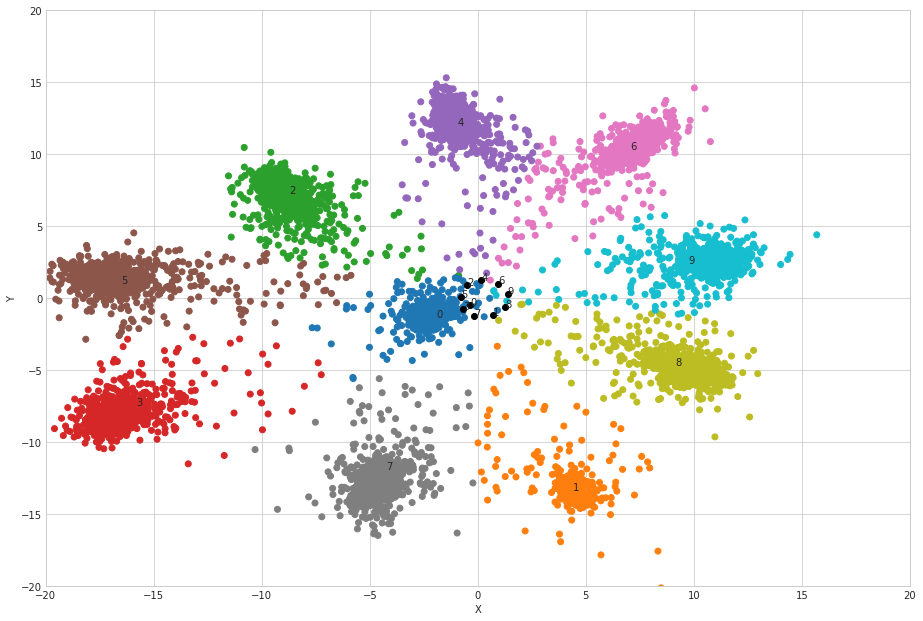

In [28]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers, class_vectors):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.class_vectors = class_vectors
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
    def plot_class_vectors(self):
        self.ax.scatter(self.class_vectors[0],self.class_vectors[1], c="black")
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.class_vectors[0,i], self.class_vectors[1,i]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers), model.out.weights[0].numpy())

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.plot_class_vectors()
myplot.show()

In [29]:
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

In [53]:
#Classification vectors
cv_x = model.out.weights[0].numpy()[0]
cv_y = model.out.weights[0].numpy()[0]

In [58]:
model.out.weights[0]

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>